# Sentiment Analysis using BERT


### Import Libraries and Set the intial variables

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### Load the data

In [107]:
p_df = pd.read_csv("/home/jamesli/github_repos/utd-summer-ai/datasets/positive_user.csv")
n_df = pd.read_csv("/home/jamesli/github_repos/utd-summer-ai/datasets/negative_user.csv")

In [108]:
p_df["label"] = [1] * len(p_df)
n_df["label"] = [0] * len(n_df)

In [109]:
p_df = p_df.iloc[:100000]
n_df = n_df.iloc[:100000]
df = pd.concat([p_df, n_df])

In [7]:
grouped = df.groupby('user')['text'].agg(list).reset_index()
# Extract the label for each user (assuming it's the same for all tweets by the same user)
grouped['label'] = df.groupby('user')['label'].first().values 

grouped.columns = ['user', 'tweet', 'label']
df = grouped[['user', 'tweet', 'label']]

In [8]:
assert df["tweet"].apply(lambda x: isinstance(x, list)).all() # make sure each element in tweet column is a list

In [9]:
class_names = ['not depressed', 'depressed']

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word.

In [10]:
# Set the model name
MODEL_NAME = 'prajjwal1/bert-tiny'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [12]:
# Store length of each review
tweet_amounts = []
tweet_lengths = []

# Iterate through the content slide
for tweet_list in df.tweet:
    for tweet in tweet_list:
        tokens = tokenizer.encode(tweet, max_length=5000)
        tweet_lengths.append(len(tokens))
    tweet_amounts.append(len(tweet_list))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Tweets per user')

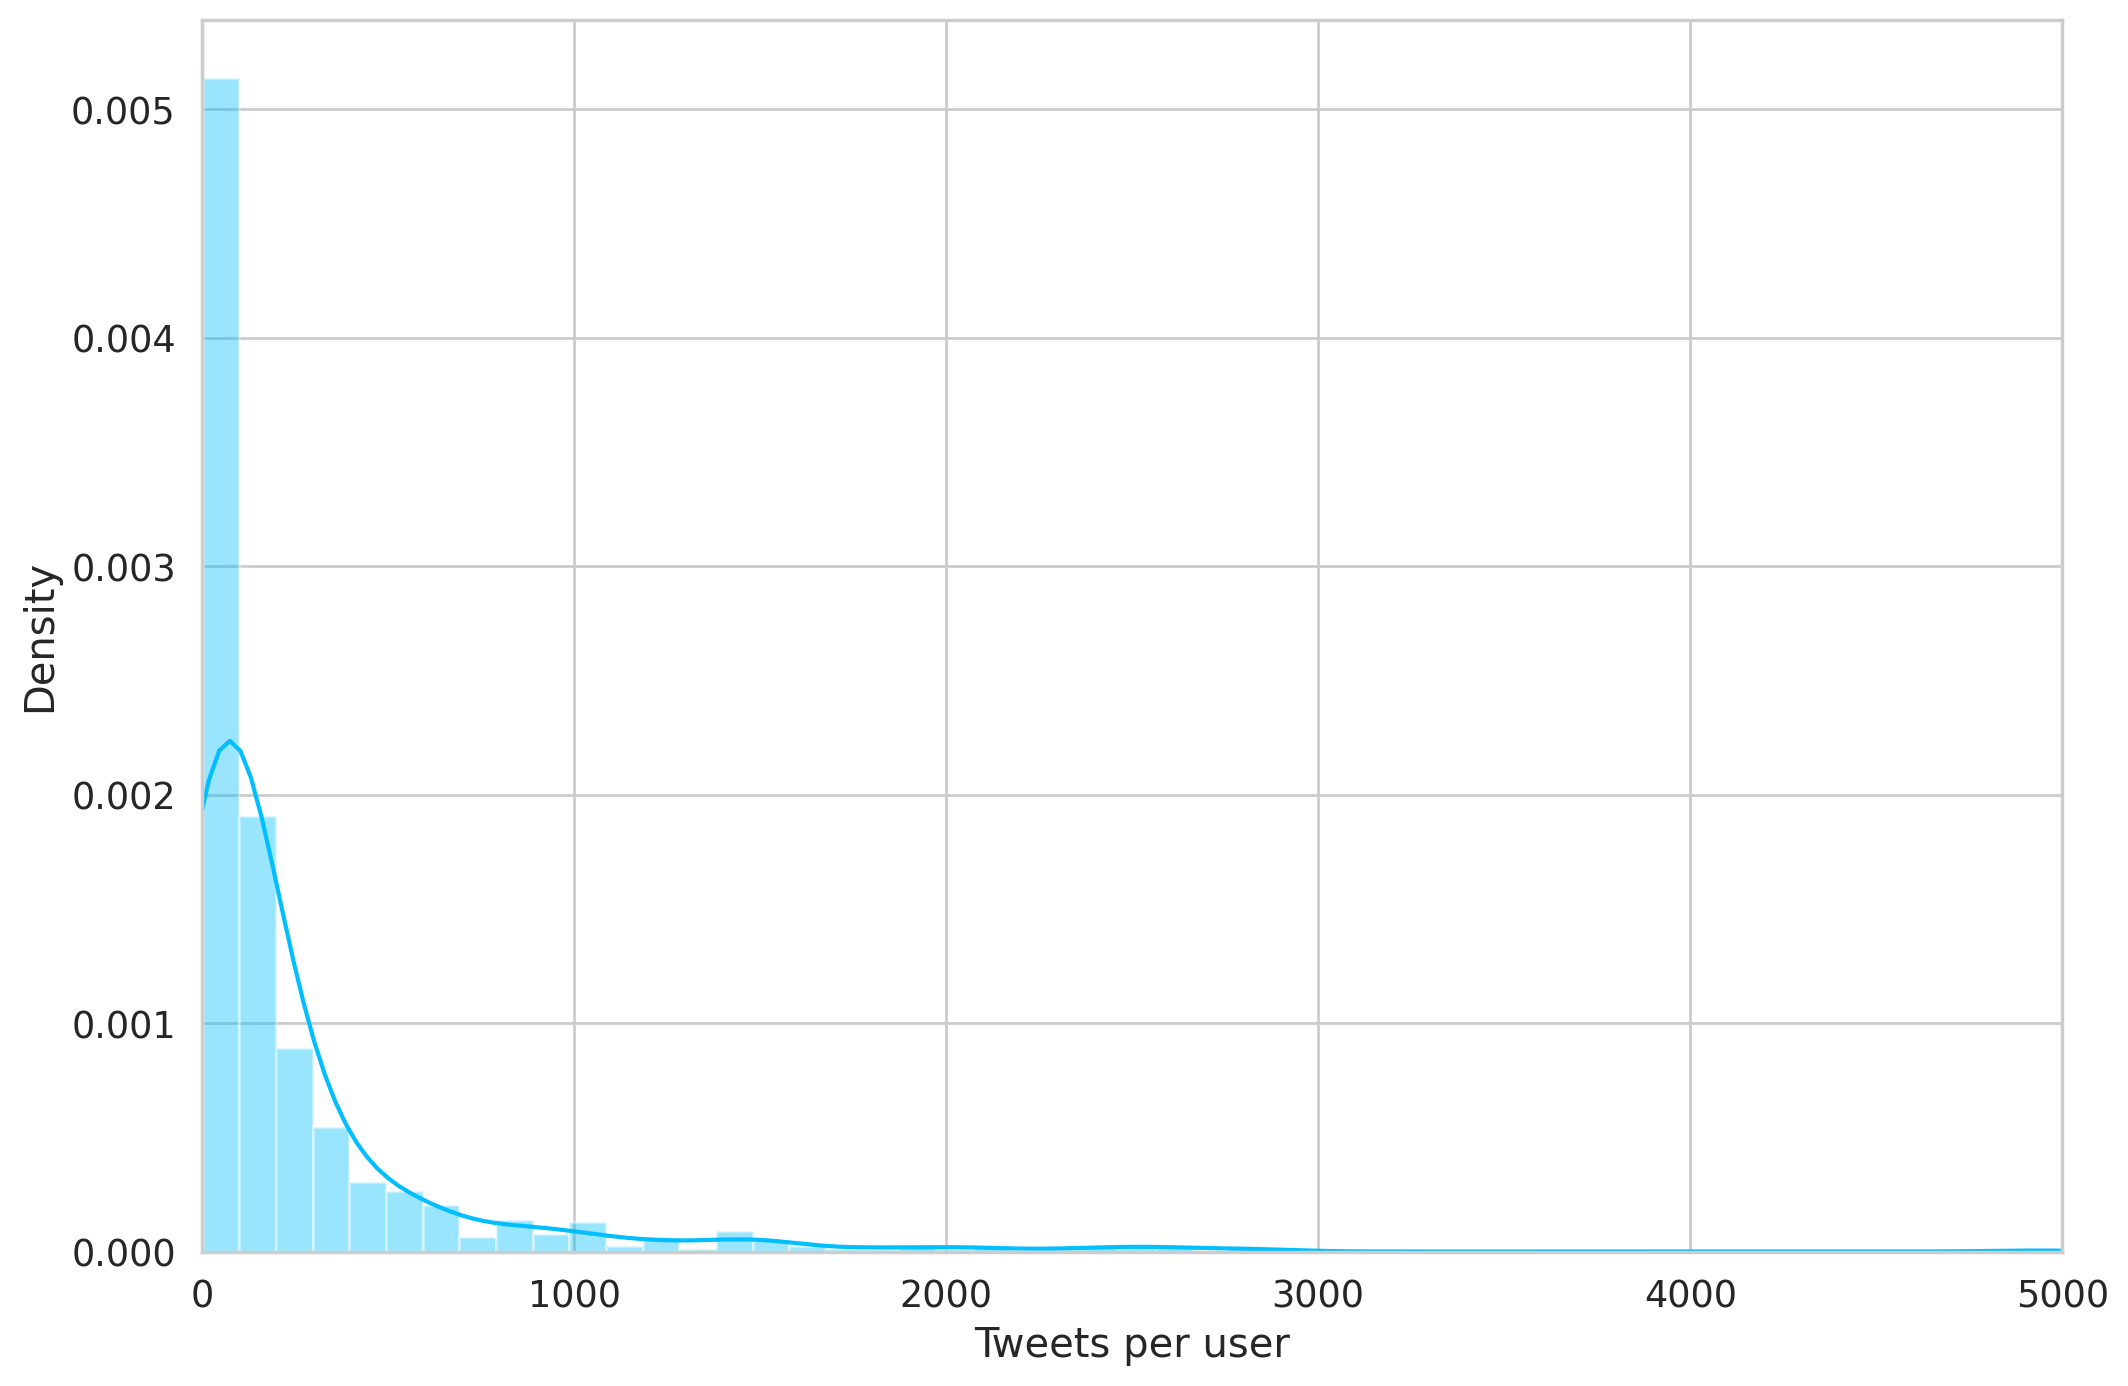

In [13]:
# plot the distribution of review lengths
sns.distplot(tweet_amounts)
plt.xlim([0, 5000]);
plt.xlabel('Tweets per user')

Text(0.5, 0, 'Tokens per tweet')

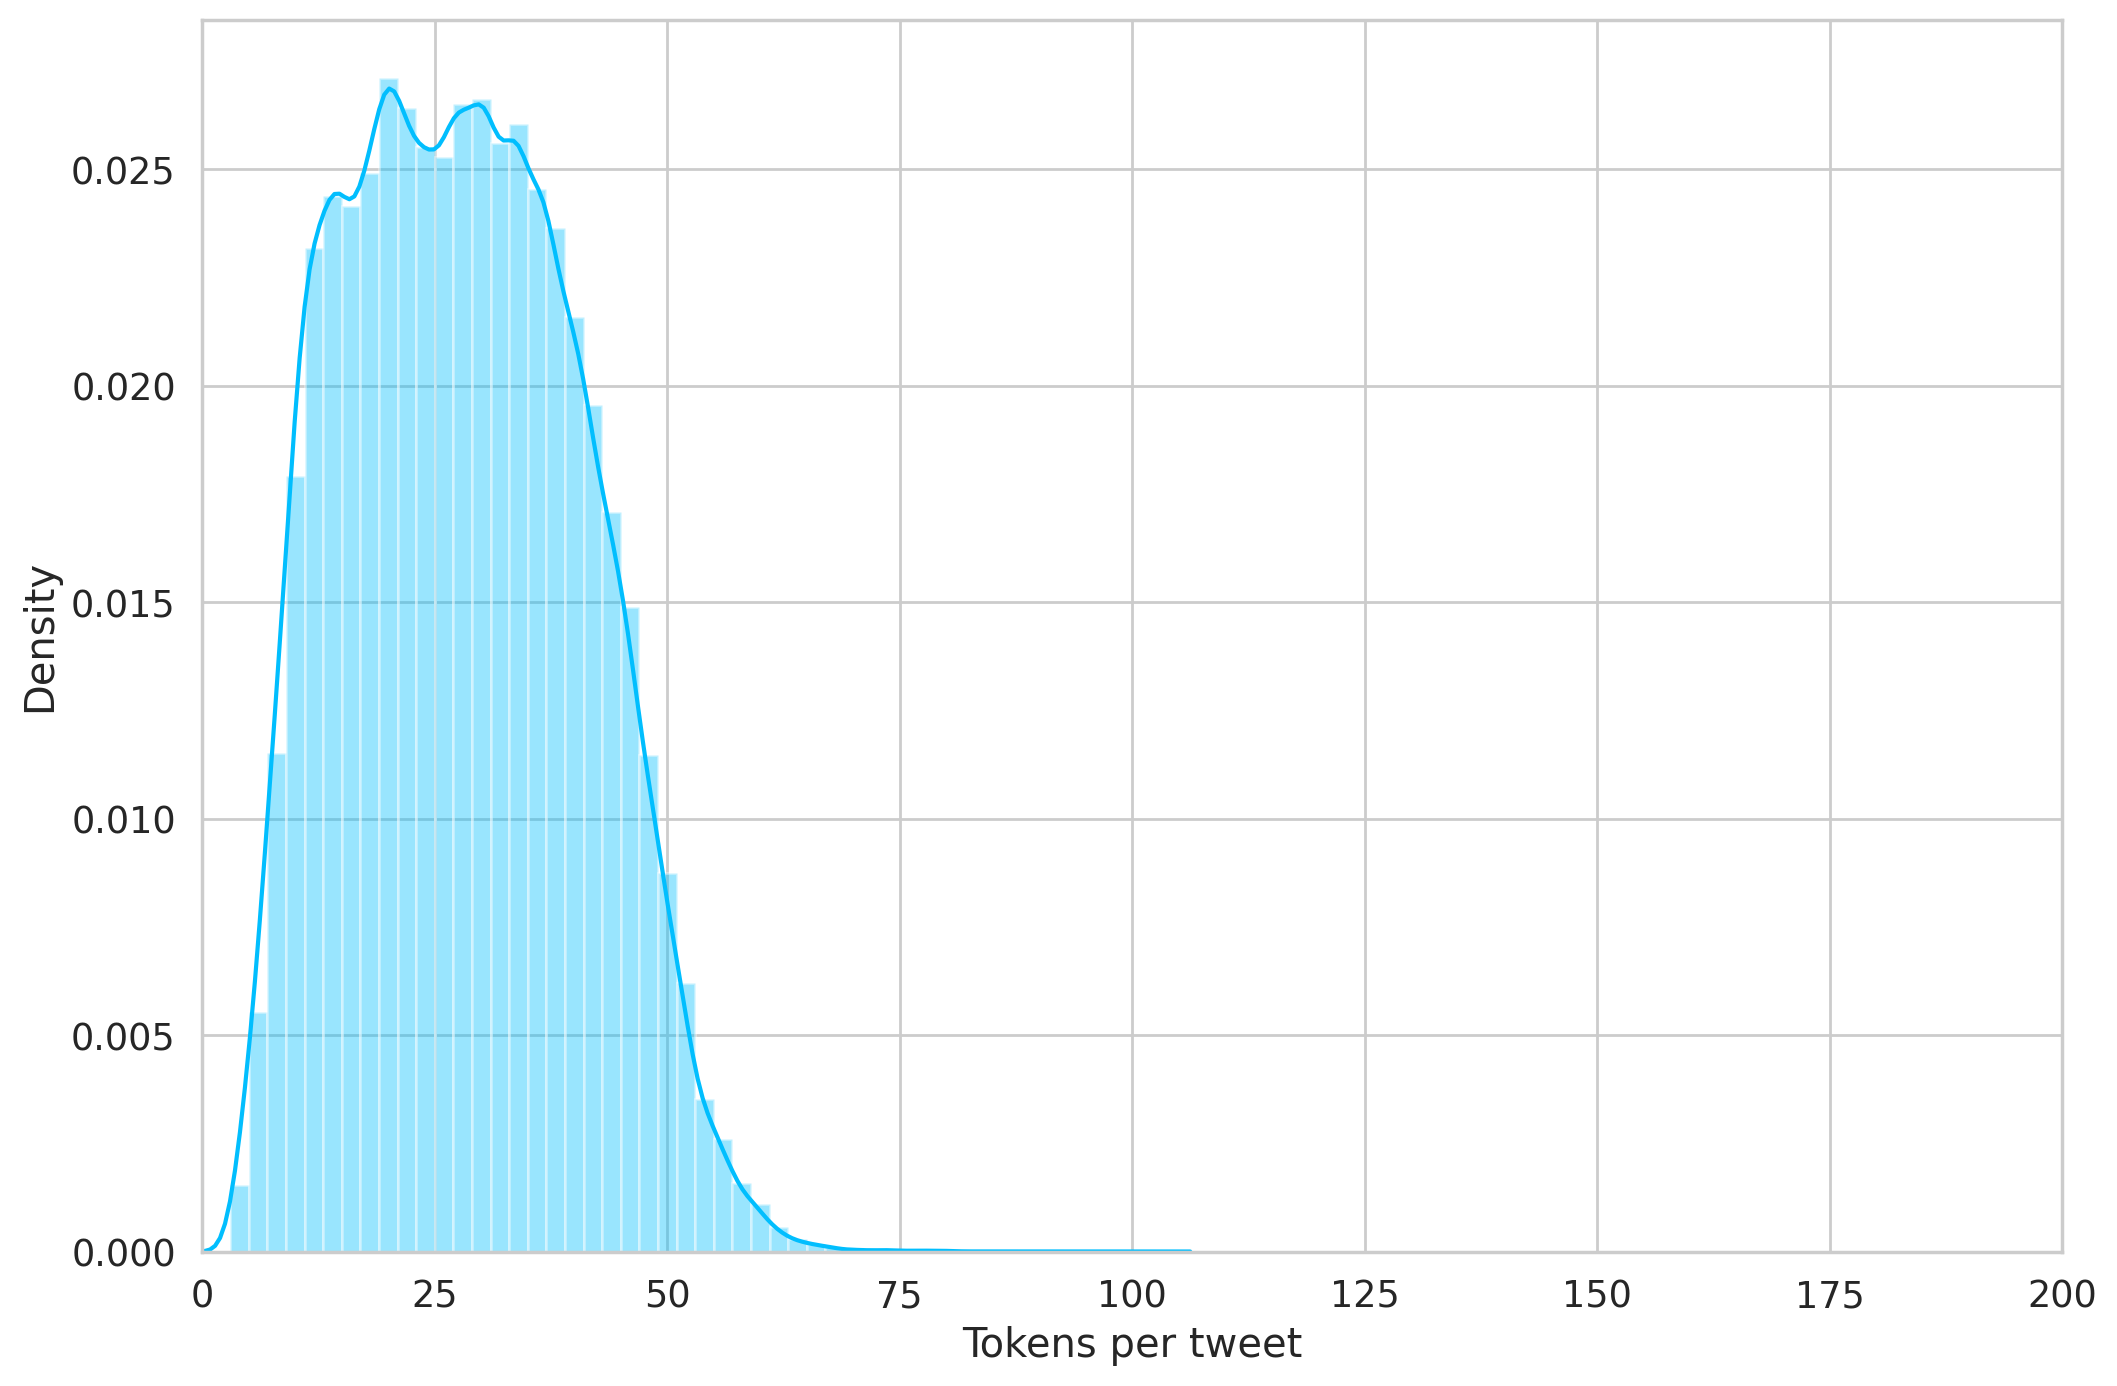

In [14]:
# plot the distribution of review lengths
sns.distplot(tweet_lengths)
plt.xlim([0, 200]);
plt.xlabel('Tokens per tweet')

In [71]:
MAX_TWEETs = 1000
MAX_LEN = 160

In [72]:
tweets = []

for tweet_list in df['tweet'].values:
  if len(tweet_list) < MAX_TWEETs:
    tweet_list.extend([""] * (MAX_TWEETs - len(tweet_list)))
  elif len(tweet_list) > MAX_TWEETs:
    tweet_list = tweet_list[:MAX_TWEETs]
  tweets.append(tweet_list)
    
df['tweet'] = tweets

In [73]:
assert set([len(t) for t in df["tweet"]]) == {MAX_TWEETs} # make sure the length of each list in tweets column is MAX_TWEETs

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [74]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = self.reviews[item]
        target = self.targets[item]
        
        # Encoded format to be returned
        encoding = [
            self.tokenizer.encode_plus(
                x,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt',
            ) for x in review
        ]
        
        if len(encoding) > MAX_TWEETs:
            encoding = encoding[:MAX_TWEETs]

        return {
            'review_text': review,
            'input_ids': [x['input_ids'].flatten() for x in encoding],
            'attention_mask': [x['attention_mask'].flatten() for x in encoding],
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [75]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(638, 3) (80, 3) (80, 3)


Create a dataloader to release data in batches.

In [76]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [77]:
BATCH_SIZE = 8

# row # must be multiple of BATCH_SIZE
df_train = df_train[:(len(df_train) // BATCH_SIZE) * BATCH_SIZE]
df_val = df_val[:(len(df_val) // BATCH_SIZE) * BATCH_SIZE]
df_test = df_test[:(len(df_test) // BATCH_SIZE) * BATCH_SIZE]

In [83]:
assert len(df_train) % BATCH_SIZE == 0
assert len(df_val) % BATCH_SIZE == 0
assert len(df_test) % BATCH_SIZE == 0

In [106]:
print(df_train.label.value_counts())
print(df_val.label.value_counts())
print(df_test.label.value_counts())

label
1    452
0    180
Name: count, dtype: int64
label
1    66
0    14
Name: count, dtype: int64
label
1    52
0    28
Name: count, dtype: int64


In [84]:
# Create train, test and val data loaders

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [85]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [86]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(input_size=128*MAX_LEN, hidden_size=50, num_layers=1, batch_first=True)
        self.out = nn.Linear(self.lstm.hidden_size, 1)

    # Forward propagation class
    def forward(self, input_ids, attention_mask):
        pooled_output = torch.zeros((BATCH_SIZE, MAX_TWEETs, MAX_LEN, 128), dtype=torch.float32)
        for x in range(0 , len(input_ids)):
            output = self.bert(input_ids=input_ids[x], attention_mask=attention_mask[x], return_dict=False)
            output = self.drop(output[0])
            with torch.no_grad():
                pooled_output[:, x].copy_(output)

        lstmOut, _ = self.lstm(pooled_output.view(BATCH_SIZE, MAX_TWEETs, 128*MAX_LEN))
        lstmOut = lstmOut[:, -1, :].view(BATCH_SIZE, 50)
        
        linear = self.out(lstmOut)
        return torch.sigmoid(linear)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [87]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [88]:
# Number of hidden units
print(bert_model.config.hidden_size)

128


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [89]:
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")  # only use cuda for training

In [90]:
# Number of iterations
EPOCHS = 2

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [91]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = [x.to(device) for x in d["input_ids"]]
        attention_mask = [x.to(device) for x in d["attention_mask"]]
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs = outputs.view(-1, 1).float()
        targets = targets.view(-1, 1).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs.round() == targets)
        losses.append(loss.item())
        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [104]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = [x.to(device) for x in d["input_ids"]]
            attention_mask = [x.to(device) for x in d["attention_mask"]]
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            outputs = outputs.view(-1, 1).float()
            targets = targets.view(-1, 1).float()

            print("OUTPUT", outputs)
            print("TARGET", targets)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs.round() == targets)
            losses.append(loss.item())

            if progress_bar:
                progress_bar.update(1)
                
    return correct_predictions.double() / n_examples, np.mean(losses)

In [93]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [94]:
%%time


from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)


    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")


    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------


Training: 100%|█████████████████████████| 79/79 [05:17<00:00,  4.20s/it]

Train loss 0.6007708145093315 accuracy 0.7056962025316456


Validation: 100%|███████████████████████| 10/10 [00:34<00:00,  3.46s/it]

Val   loss 0.45569001585245134 accuracy 0.8250000000000001

Epoch 2/2
----------


Training: 100%|█████████████████████████| 79/79 [05:16<00:00,  4.09s/it]

Train loss 0.589561660455752 accuracy 0.7151898734177216


Validation: 100%|███████████████████████| 10/10 [00:37<00:00,  3.77s/it]

Val   loss 0.4533186793327332 accuracy 0.8250000000000001

CPU times: user 11min 46s, sys: 307 ms, total: 11min 46s
Wall time: 11min 46s


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

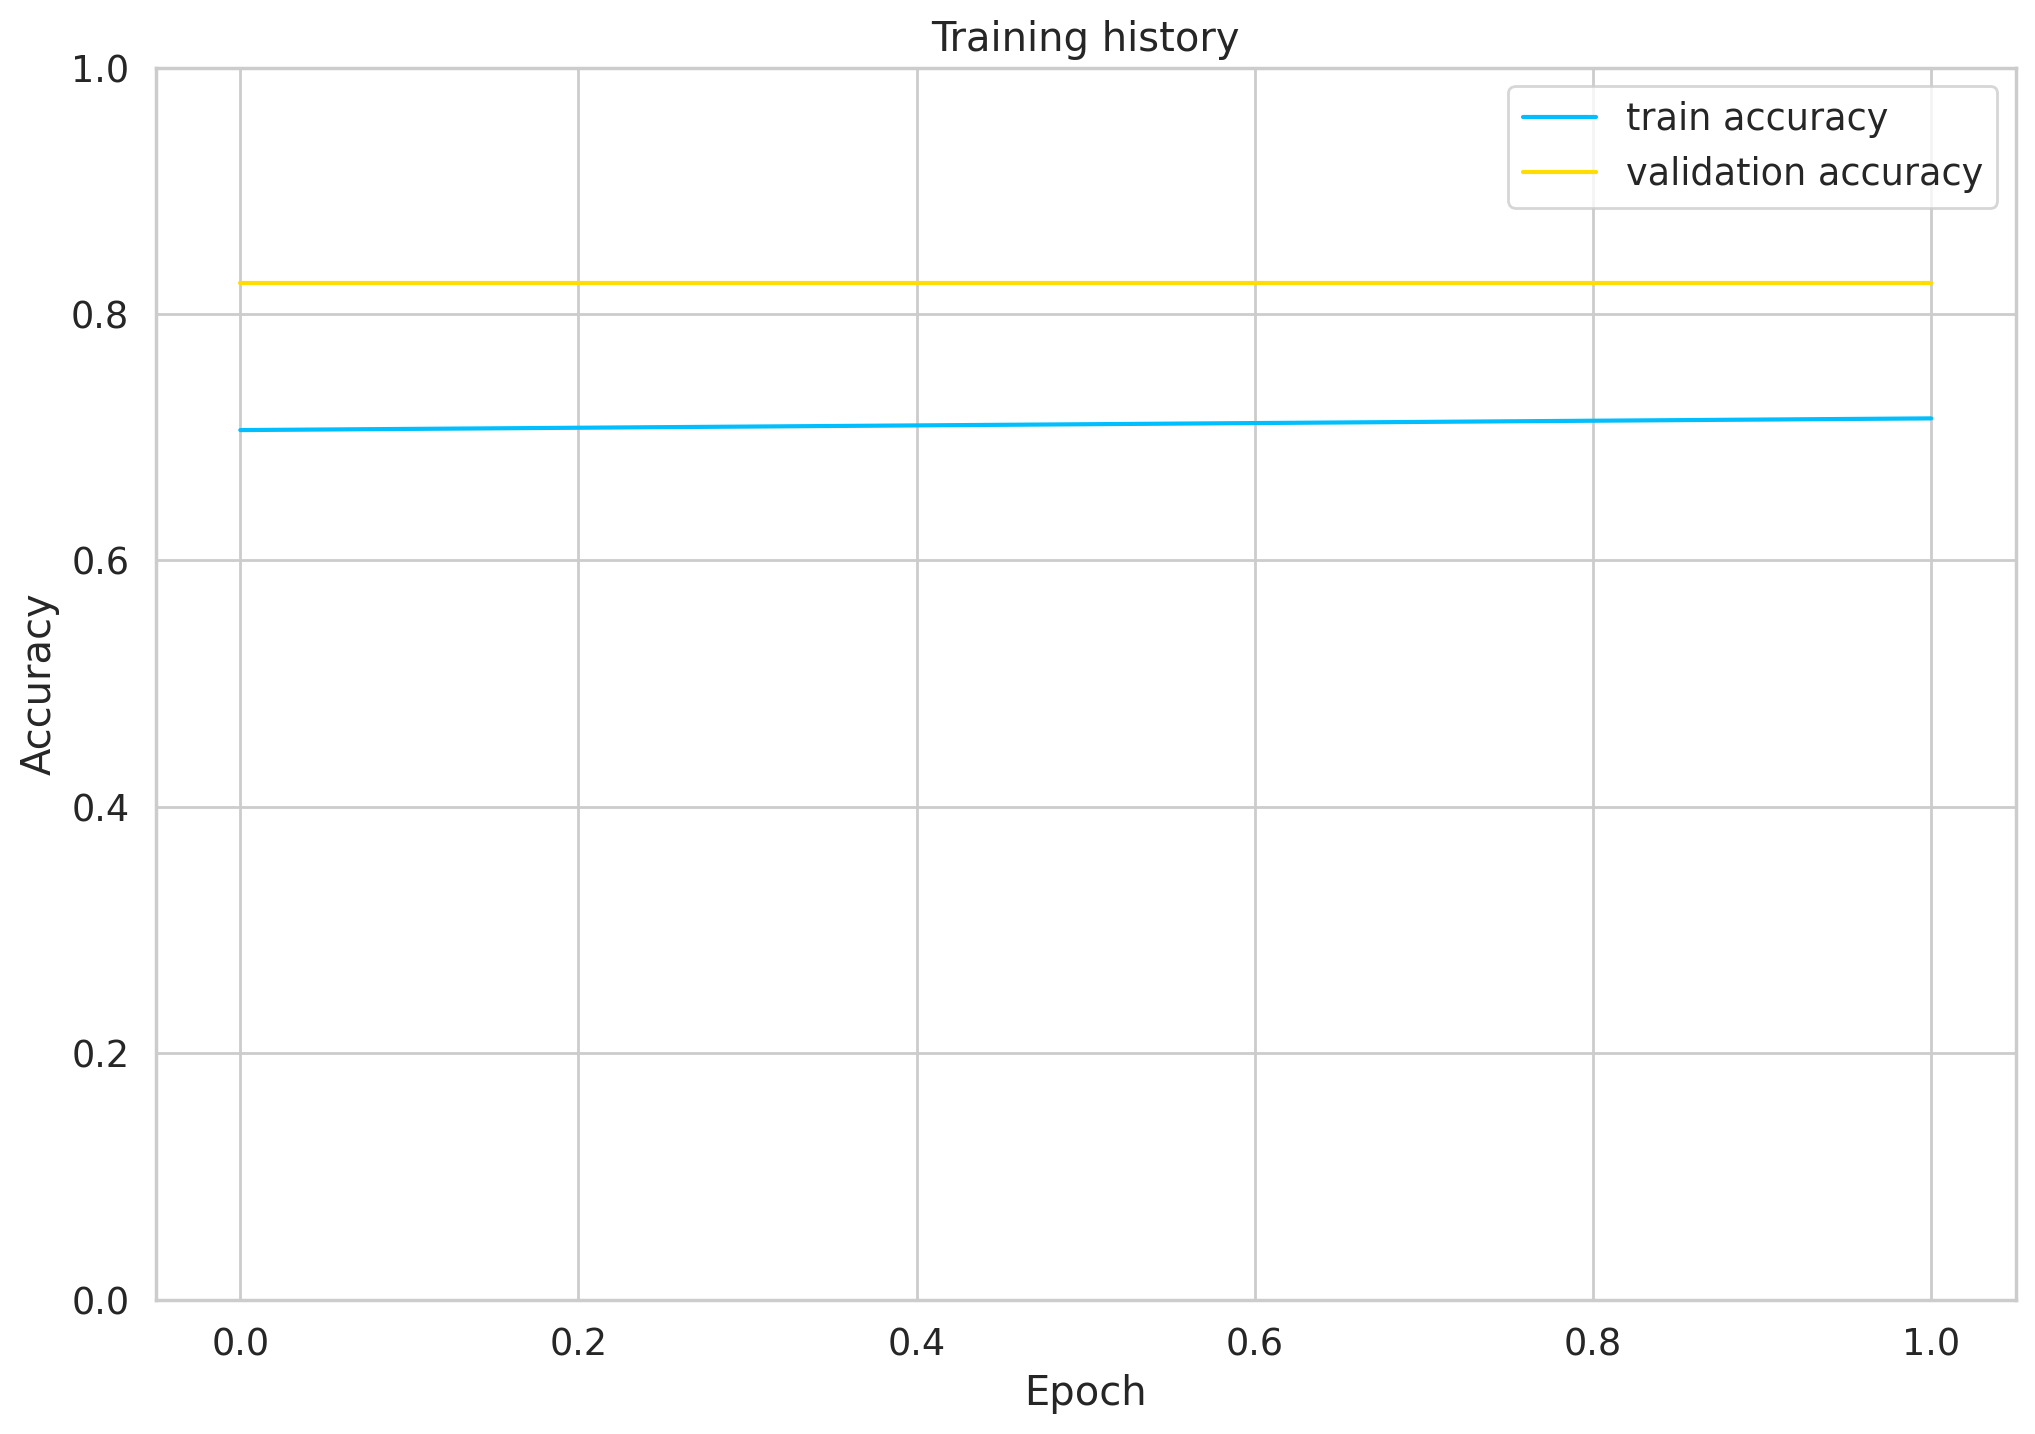

In [95]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [105]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

OUTPUT tensor([[0.8076],
        [0.8002],
        [0.8076],
        [0.8015],
        [0.8076],
        [0.8062],
        [0.8076],
        [0.7987]], device='cuda:0')
TARGET tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cuda:0')
OUTPUT tensor([[0.8076],
        [0.7987],
        [0.8076],
        [0.7999],
        [0.8076],
        [0.7967],
        [0.8085],
        [0.8186]], device='cuda:0')
TARGET tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')
OUTPUT tensor([[0.8079],
        [0.8087],
        [0.6726],
        [0.8078],
        [0.7986],
        [0.8083],
        [0.8076],
        [0.8179]], device='cuda:0')
TARGET tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
OUTPUT tensor([[0.5580],
        [0.8010],
        [0.8121],
        [0.8005],
   

0.65

In [97]:
test_data_loader.dataset.targets

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [98]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = [x.to(device) for x in d["input_ids"]]
            attention_mask = [x.to(device) for x in d["attention_mask"]]
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.flatten(outputs.round())

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [99]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [100]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.00      0.00      0.00        28
    depressed       0.65      1.00      0.79        52

     accuracy                           0.65        80
    macro avg       0.33      0.50      0.39        80
 weighted avg       0.42      0.65      0.51        80



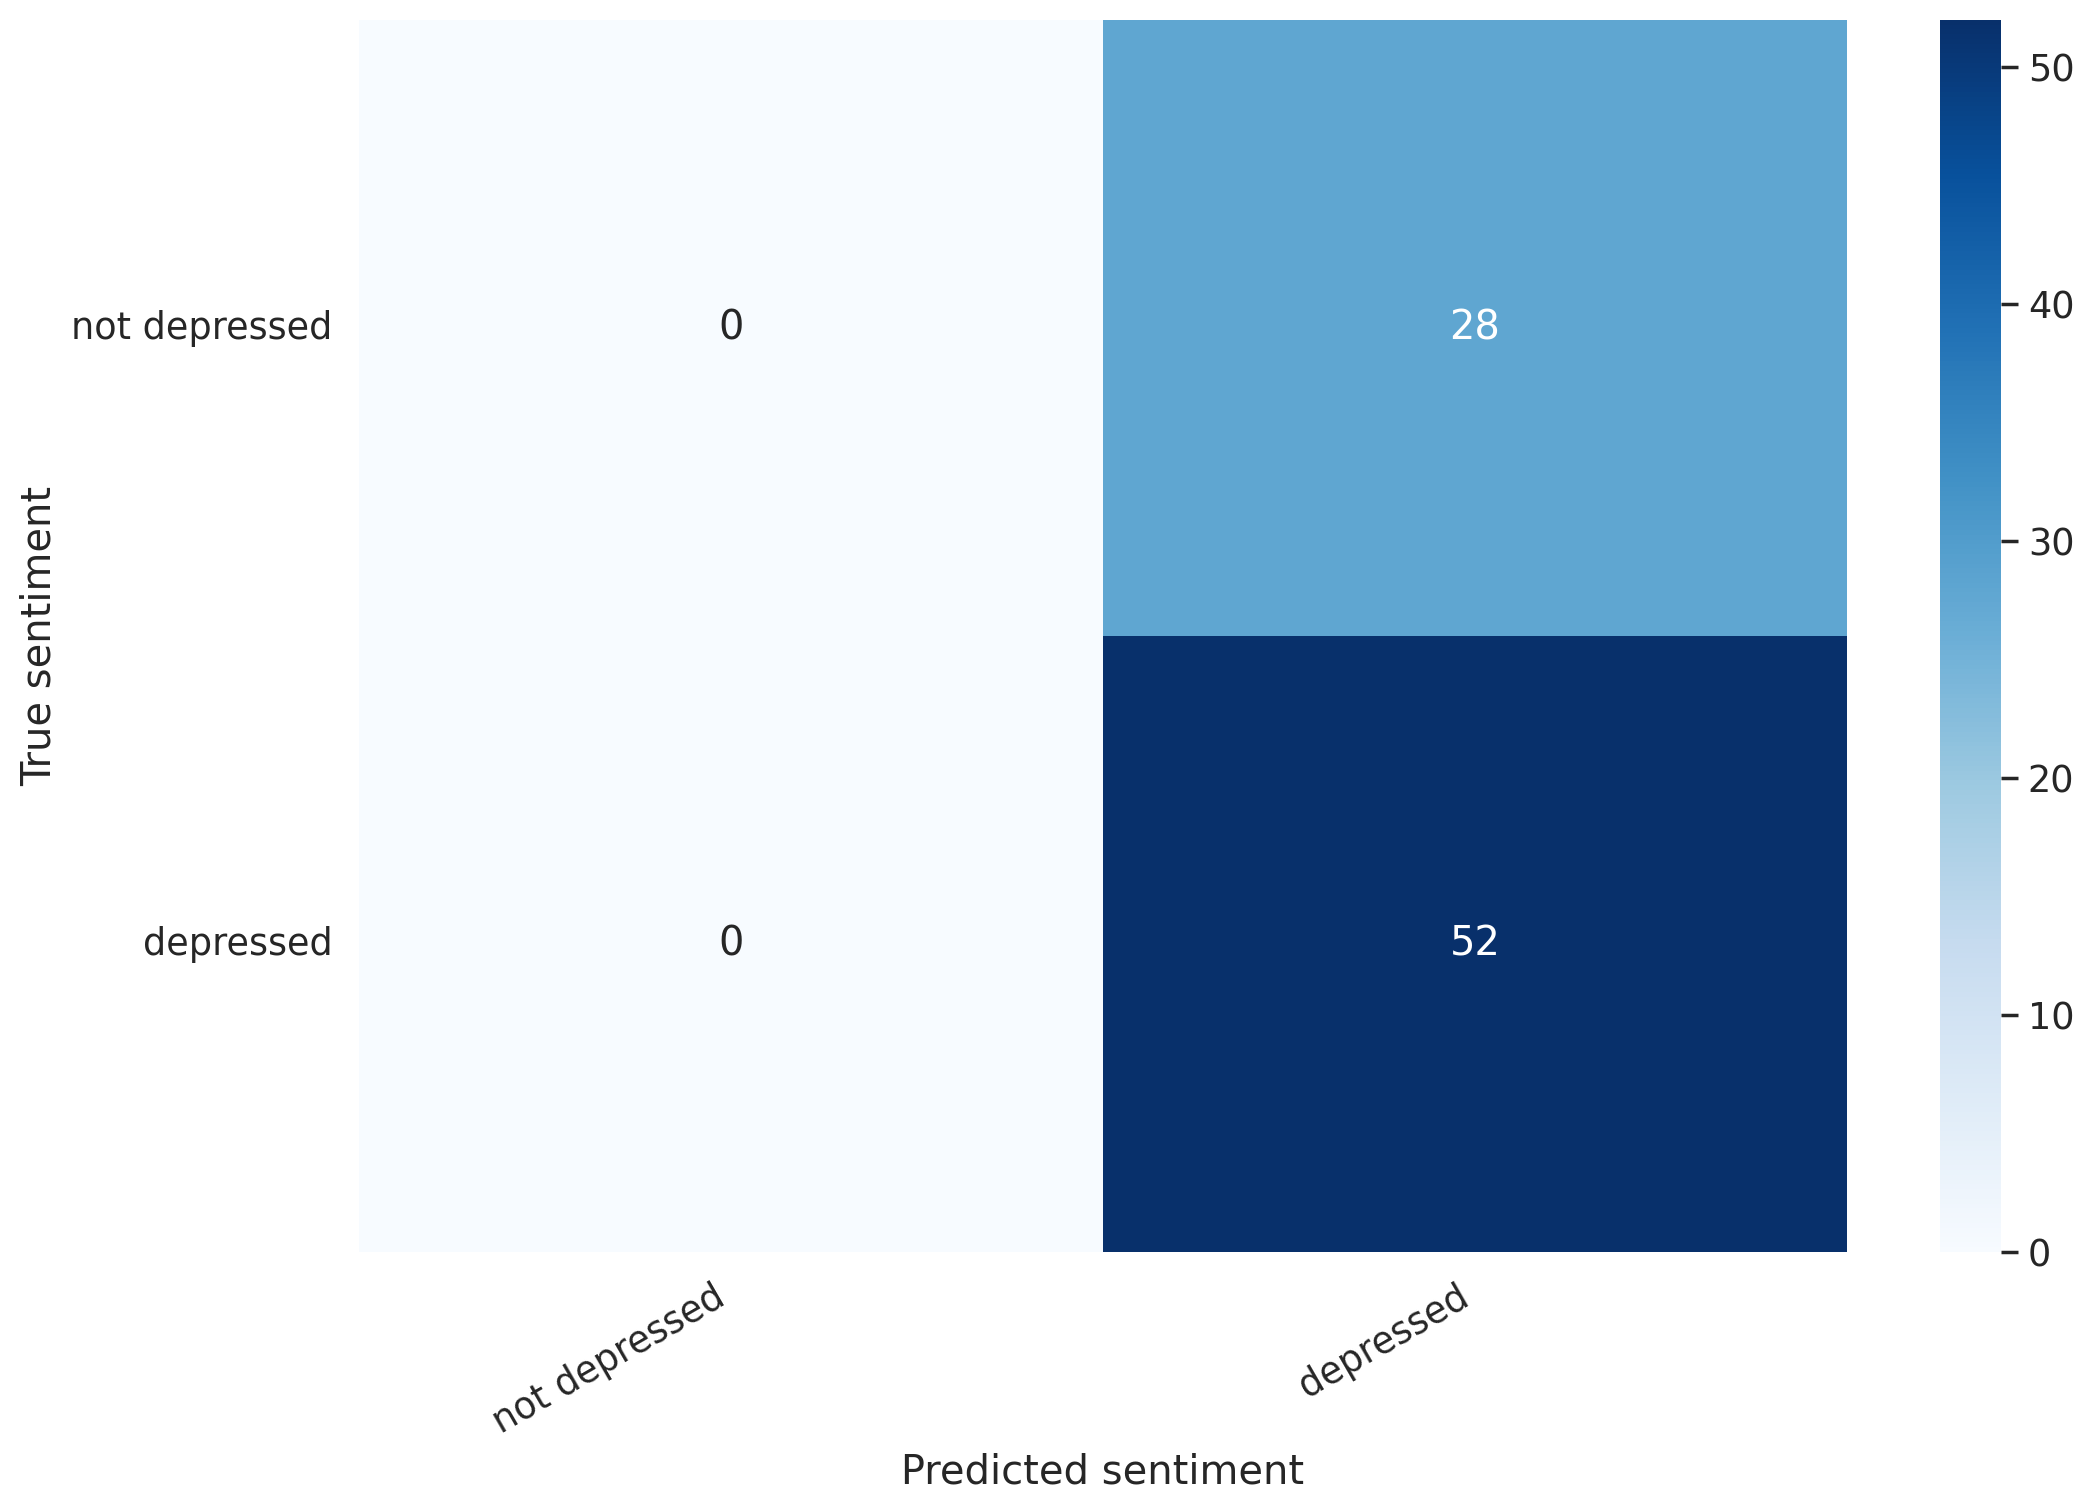

In [101]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
review_text = "I have depression h"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I have depression sadly
Sentiment  : depressed


In [ ]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
model = torch.load("model.pt", map_location=torch.device('cpu'))

print(type(model))

<class 'collections.OrderedDict'>


In [ ]:

model = SentimentClassifier(len(class_names))
model.load_state_dict(test)



<All keys matched successfully>